In [25]:
#Building a Neural Net Multi-lay Perceptron

import numpy as np
import sys

class NeuralNetMLP(object):
    """Feedforward neural network / Multi-layer perceptron
    classifier. 
    
    Parameters
    -----------
    
    n_hidden: int (default: 30)
        Number of hidden units.
    
    l2 : float (default: 0)
        Lambda value for L2-regularization.
        No regularization if l2 = 0. (default)
        
    epochs: int (default: 100)
        Number of passes over the training set.
    
    eta: float (default: 0.001)
        Learning rate.
    
    shuffle: bool (default: True)
        Shuffles training data every epoch
        if True to prevent circles.
    
    minibatch_size: int (default: 1)
        Number of training samples per minibatch.
    
    seed: int (default: None)
        Random seed for initializing weights and shuffling.
        
    
    Attributes
    ----------
    
    eval_: dict
        Dictionary collecting the cost, training accuracy,
        and validation accuracy for each epoch during training.
    
    """
    
    def __init__(self, n_hidden = 30,
                l2 = 0, epochs = 100, eta = 0.001,
                shuffle = True, minibatch_size = 1, seed = None):
        
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    
    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation
        
        Parameters
        ----------
        
        y: array, shape = [n_samples]
            Target values.
        
        Returns
        --------
        
        onehot: array, shape = (n_samples, n_labels)
        
        """
        
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        
        return onehot.T
    
    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def _forward(self, X):
        """Compute forward propagation step"""
        
        #Step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        
        z_h = np.dot(X, self.w_h) + self.b_h
        
        #step 2: activation of hidden layer
        
        a_h = self._sigmoid(z_h)
        
        #Step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]
        
        z_out = np.dot(a_h, self.w_out) + self.b_out
        
        #step 4: activation of output layer
        
        a_out = self._sigmoid(z_out)
        
        return z_h, a_h, z_out, a_out
    
    def _compute_cost(self, y_enc, output):
        """computer cost function.
        
        Parameters
        ----------
        
        y_enc: array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        
        output: array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)
        
        Returns
        -------
        
        cost: float
            Regularization cost
        
        """
        
        L2_term = (self.l2 * 
                  (np.sum(self.w_h ** 2.) + 
                  np.sum(self.w_out ** 2.)))
        
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        return cost
    
    def predict(self, X):
        """Predict class labels
        
        Parameters
        ----------
        
        X: array, shape = [n_samples, n_features]
            Input layer with original features.
        
        Returns
        -------
        
        y_pred: array, shape = [n_samples]
            Predicted class labels.
        
        """
        
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis = 1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        """Learn weights from training data.
        
        Parameters
        ----------
        
        X_train: array, shape = [n_samples, n_features]
            Input layer with original features.
            
        y_train: array, shape = [n_samples]
            Target class labels
            
        X_valid: array, shape = [n_samples, n_features]
            Sample features for validation during training
            
        y_valid: array, shape = [n_samples]
            Sample labels for validation during training
            
        Returns:
        --------
        self
        
        """
        n_output = np.unique(y_train).shape[0] # no. of class labels
    
        
        n_features = X_train.shape[1]
        
        ########################
        # Weight initialization
        ########################
        
        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc = 0.0, scale = 0.1,
                                     size = (n_features,
                                            self.n_hidden))
        #weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc = 0.0, scale = 0.1, 
                                       size = (self.n_hidden,
                                              n_output))
        
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
        y_train_enc = self._onehot(y_train, n_output)
        
        # iterate over training epochs
        for i in range(self.epochs):
            #iterate over mini-batches
            
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)
                
            for start_idx in range(0, indices.shape[0] -\
                                  self.minibatch_size +\
                                  1, self.minibatch_size):
                batch_idx = indices[start_idx: start_idx +\
                                   self.minibatch_size]
                
                # forward propagation
                z_h, a_h, z_out, a_out =\
                    self._forward(X_train[batch_idx])
                
                ###################
                # Backpropagation
                ###################
                
                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                
                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                
                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_hidden, n_classlabels]
                
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                          sigmoid_derivative_h)
                
                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis = 0)
                
                #[n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis = 0)
                
                #Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                delta_w_out = (grad_w_out + self.l2 * self.w_out)
                delta_b_out = grad_b_out # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
                
            #############
            # Evaluation 
            #############
            
            #Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc = y_train_enc,
                                     output = a_out)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == 
                                y_train_pred)).astype(np.float) /
                                X_train.shape[0])
            valid_acc = ((np.sum(y_valid ==
                                y_valid_pred)).astype(np.float) /
                                X_valid.shape[0])
            
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                            ' | Train/Valid Acc.: %.2f%%/%.2f%%'
                            %
                            (epoch_strlen, i+1, self.epochs,
                            cost,
                            train_acc * 100, valid_acc * 100))
            
            sys.stderr.flush()
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
            
        return self
        



In [ ]:
#Implimenting a Neural Net Multi-lay Perceptron
nn = NeuralNetMLP(n_hidden=100,
                 l2 = 0.01,
                 epochs=200,
                 eta = 0.0005,
                 minibatch_size=100,
                 shuffle=True,
                 seed = 1)

In [ ]:
#We can now load the preprocessed image arrays
mnist = np.load('mnist_scaled.npz')

mnist.files

X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

In [ ]:
#Fitting the NNMLP - both the training and the validation set at the same time

nn.fit(X_train=X_train[:55000],
         y_train=y_train[:55000],
         X_valid=X_train[55000:],
         y_valid=y_train[55000:])

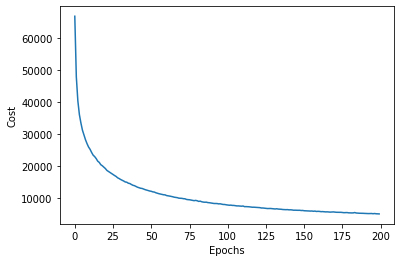

In [28]:
#The implimentation also has an eval_ attribute that
# collects the costs, training, and validation accuracy for each epoch
# we can then visualize this

import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

#We can see that there is a steep drop of in cost from 0 to ~50
# continues to decrease even after 200 epochs so we could continue with more epochs

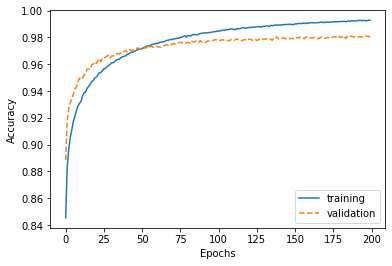

In [29]:
# Next looking at the training and test accuracy

plt.plot(range(nn.epochs), nn.eval_['train_acc'],
        label = 'training')

plt.plot(range(nn.epochs), nn.eval_['valid_acc'],
        label = 'validation', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

#What this shows is the validation accurracy drops off after ~ 50 epochs
# it is overfit after this point
#Can decrease the effect of overfitting by increasing the penalization parameter (l2) to .1
# instead of .01


In [32]:
#Generalization performance by calculating the prediction accuracy
# on the test set

y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred).
      astype(np.float) / X_test.shape[0])

print('Training accuracy: %.2f%%' % (acc * 100))

#Similar results to the validation score of 98% 
#Overall good performance

Training accuracy: 97.54%


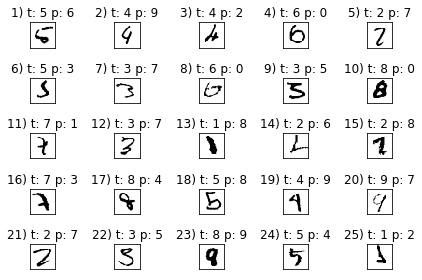

In [34]:
#Now we can look at the images where the model struggled

miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows = 5,
                      ncols = 5,
                      sharex = True,
                      sharey=True)

ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys',
                interpolation = 'nearest')
    ax[i].set_title('%d) t: %d p: %d' %
                    (i + 1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

#Some of the numbers are even difficult to classify with just looking